# Fault detection (Research)

Here we will demonstrate the research process of fault detection models. We will train multiple 2D and 3D models on all posible combinations of seismic cubes.

In [1]:
import sys
import os
from copy import copy
import itertools

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook


sys.path.append('../..')

from seismiqb import *

from seismiqb.batchflow import FilesIndex, Pipeline
from seismiqb.batchflow.research import Option, Research, RP, RC, RD, REP, KV, RI
from seismiqb.batchflow.models.torch import EncoderDecoder, ResBlock, TorchModel
from seismiqb.batchflow import D, B, V, P, R, L, W, C
from seismiqb.batchflow.models.torch.losses.binary import Dice, Tversky, SSLoss, BCE

import warnings
warnings.filterwarnings("ignore")

Here we describe model configuration. In general it is UNet-like architecture where we fix some parameters but all of them are also is a subject of research.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

ITERS = 2000
BATCH_SIZE = 32
FILTERS = [64, 96, 128, 192, 256]

MODEL_CONFIG = {
    # Model layout
    'initial_block': {
        'base_block': ResBlock,
        'filters': FILTERS[0] // 2,
        'kernel_size': 5,
        'downsample': False,
        'attention': 'scse'
    },

    'body/encoder': {
        'num_stages': 4,
        'order': 'sbd',
        'blocks': {
            'base': ResBlock,
            'n_reps': 1,
            'filters': FILTERS[:-1],
            'attention': 'scse',
        },
    },
    'body/embedding': {
        'base': ResBlock,
        'n_reps': 1,
        'filters': FILTERS[-1],
        'attention': 'scse',
    },
    'body/decoder': {
        'num_stages': 4,
        'upsample': {
            'layout': 'tna',
            'kernel_size': 2,
        },
        'blocks': {
            'base': ResBlock,
            'filters': FILTERS[-2::-1],
            'attention': 'scse',
        },
    },
    'head': {
        'base_block': ResBlock,
        'filters': [16, 8],
        'attention': 'scse'
    },
    'output': torch.sigmoid,
    # Train configuration
    'loss': C('loss'),
    'optimizer': {'name': 'Adam', 'lr': 0.005,},
    "decay": {'name': 'exp', 'gamma': 0.1, 'frequency': 150},
    'microbatch': 8,
    'common/activation': 'relu6',
}

The whole training process is described by the following pipeline. We will vary crop shape (2D (1, 128, 256) and 3D (32, 128, 256)) so define it as a `C('crop')` to use with `Research` from `batchflow`.

In [3]:
train_pipeline = (
    Pipeline()
    # Initialize pipeline variables and model
    .init_variable('loss_history', [])
    .init_model('dynamic', EncoderDecoder, 'model', MODEL_CONFIG)

    # Load data/masks
    .crop(points=D('train_sampler')(BATCH_SIZE), shape=C('crop'), side_view=False)
    .create_masks(dst='masks', width=1)
    .mask_rebatch(src='masks', threshold=0.5, axis=(0, 1))
    .load_cubes(dst='images')
    .adaptive_reshape(src=['images', 'masks'], shape=C('crop'))
    .scale(mode='q', src='images')

    # Augmentations
    .transpose(src=['images', 'masks'], order=(1, 2, 0))
    .flip(axis=1, src=['images', 'masks'], seed=P(R('uniform', 0, 1)), p=0.3)
    .additive_noise(scale=0.005, src='images', dst='images', p=0.3)
    .rotate(angle=P(R('uniform', -40, 40)),
            src=['images', 'masks'], p=0.3)
    .scale_2d(scale=P(R('uniform', 0.85, 1.15)),
              src=['images', 'masks'], p=0.3)
    .transpose(src=['images', 'masks'], order=(2, 0, 1))

    # Training
    .train_model('model',
                 fetches='loss',
                 images=B('images'),
                 masks=B('masks'),
                 save_to=V('loss_history', mode='w'))
    .run_later(D('size'), n_iters=ITERS)
)

In [4]:
def compute_metrics(pipeline, test_cube, path, config, step=100):
    dataset = SeismicCubeset(FilesIndex(path=[test_cube], no_ext=True))
    dataset.load_geometries()
    cube = dataset.geometries[0]
    
    crop_shape = list(config.config()['crop'])
    grid = np.arange(0, cube.cube_shape[0]-crop_shape[0]+1, step)
    
    stride = tuple(np.maximum((np.array(crop_shape) * 3/4).astype(int), np.array([1,1,1])))
    inference_template = (
        Pipeline()
        # Initialize everything
        .init_variable('result_preds', [])
        .import_model('model', pipeline)
#         .load_model(mode='dynamic', model_class=TorchModel, name='model', path=model_path)
        # Load data
        .crop(points=D('grid_gen')(),
              shape=crop_shape)
        .load_cubes(dst='images')
        .adaptive_reshape(src='images', shape=crop_shape)
        .scale(mode='q', src='images')

        # Predict with model, then aggregate
        .predict_model('model',
                       B('images'),
                       fetches='sigmoid',
                       save_to=V('result_preds', mode='e'))
    )
    points = []
    sem = []
    for i, start in enumerate(grid):
        if i == len(grid) - 1:
            stop = cube.cube_shape[0]
        else:
            stop = min(grid[i+1], cube.cube_shape[0])
        dataset.make_grid(dataset.indices[0], crop_shape,
                          [start, stop], [0, cube.cube_shape[1]-1],
                          [0, cube.cube_shape[2]-1],
                          strides=stride,
                          batch_size=8) 
        inference_pipeline = inference_template << dataset
        for _ in range(dataset.grid_iters):
            batch = inference_pipeline.next_batch(D('size'))

        prediction = (dataset.assemble_crops(inference_pipeline.v('result_preds'), order=(0, 1, 2)) > 0.5).astype(int)
        _points = np.where(prediction)
        if len(_points[0]) > 0:
            _points = (_points[0]+start, _points[1], _points[2])
            _points = np.stack(_points, axis=-1)
            points += [_points]
            chunk_sem = cube.compute_attribute(points=_points,
                                               locations=(slice(start, stop), slice(None), slice(None)),
                                               attribute='semblance')
            sem += [[np.nansum(chunk_sem), (1 - np.isnan(chunk_sem)).sum()]]
    if len(points) > 0:
        points = np.concatenate(points, axis=0)

        fault_map = np.zeros(cube.cube_shape[:2])
        fault_map[points[:, 0], points[:, 1]] = 1
        plt.figure(figsize=(15, 15))
        plt.imshow(fault_map)
        plt.savefig(path + '/fault_map.png')

        sem = np.array(sem)
        return sem[:, 0].sum() / sem[:, 1].sum()
    else:
        return np.nan

Here we describe two callables: to create dataset from paths to cubes and to dump the resulting model.

In [5]:
def create_dataset(pipeline, config):
    paths = list(config.config()['paths'])
    dataset = SeismicCubeset(FilesIndex(path=paths, no_ext=True))
    dataset.load(label_dir='/INPUTS/FAULTS/NPY/*', labels_class=Fault, transform=True, verify=True)
    dataset.modify_sampler(dst='train_sampler', finish=True, low=0.0, high=1.0)
    pipeline.set_dataset(dataset)

In [6]:
def dump_model(pipeline, path, iteration):
    path = os.path.join(path, 'model_'+str(iteration))
    pipeline.save_model_now('model', path)

Now we construct all possible combinations of 4 availiable cubes.

In [7]:
datasets = ['/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.hdf5',
            '/data/seismic_data/seismic_interpretation/CUBE_16_PSDM/amplitudes_16_PSDM.hdf5',
#             '/data/seismic_data/seismic_interpretation/CUBE_22_VALYNTOY/amplitudes_22_VALYNTOY.hdf5',
#             '/data/seismic_data/seismic_interpretation/CUBE_23_VYNGAYAHA/amplitudes_23_VYNGAYAHA.hdf5',
            ]

In [8]:
dataset = SeismicCubeset(FilesIndex(path=datasets, no_ext=True))

dataset.load(label_dir='/INPUTS/FAULTS/NPY/*', labels_class=Fault)
dataset.modify_sampler(dst='train_sampler', finish=True)

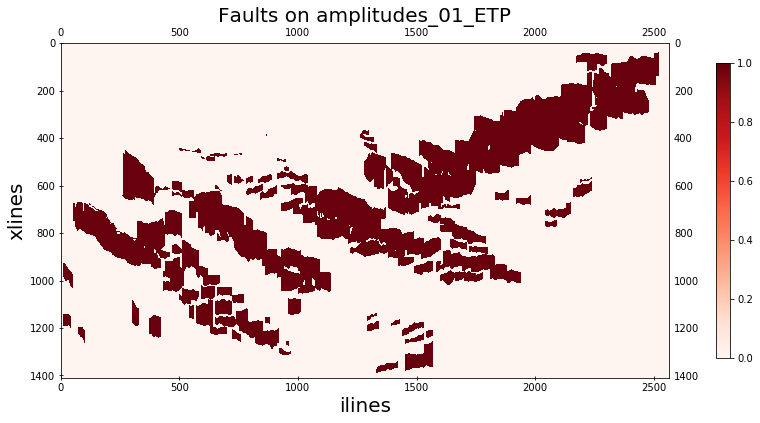

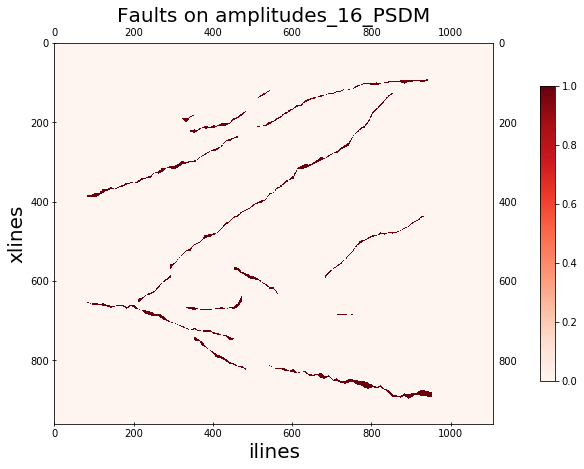

In [9]:
for i in range(len(datasets)):
    dataset.show_points(i)

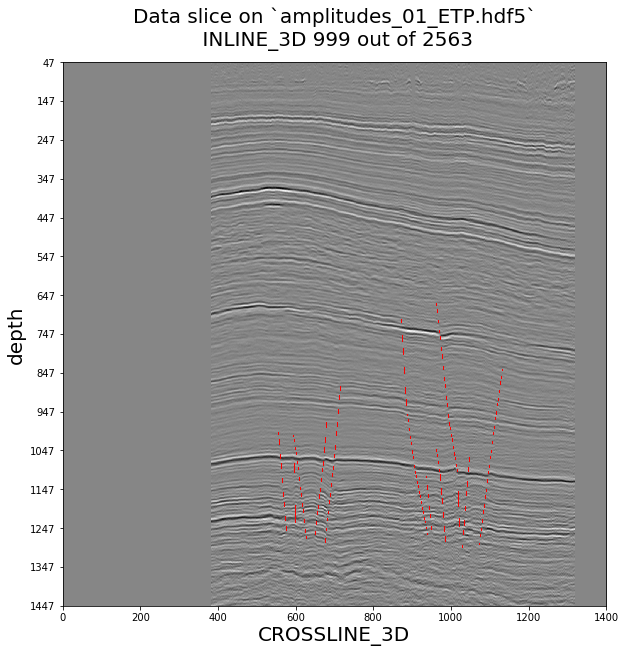

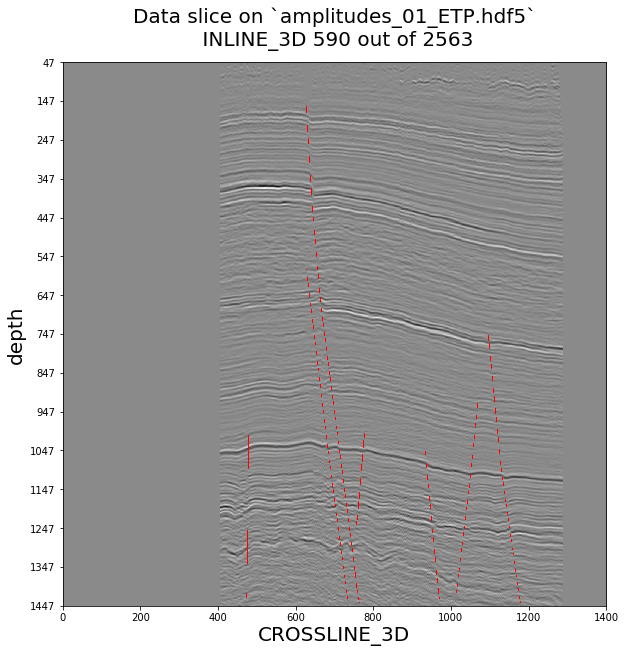

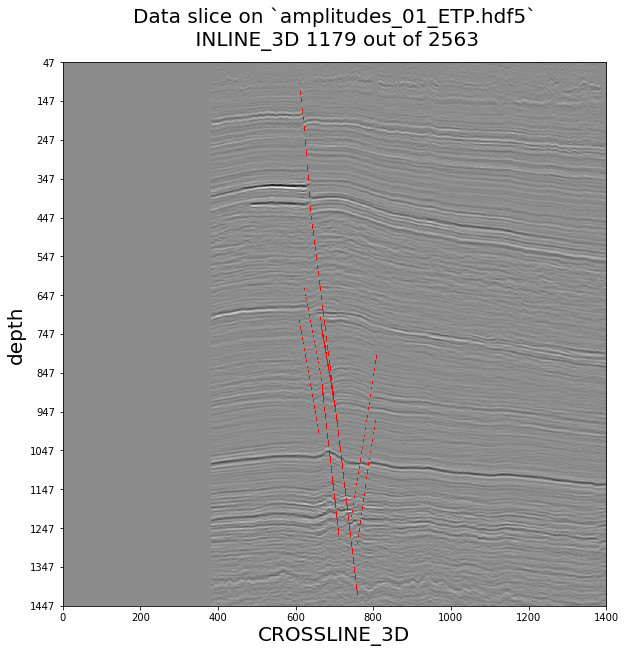

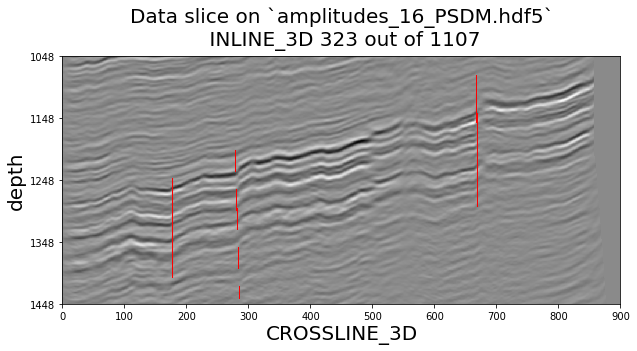

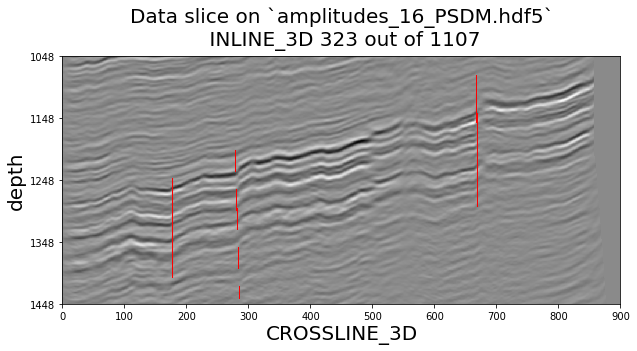

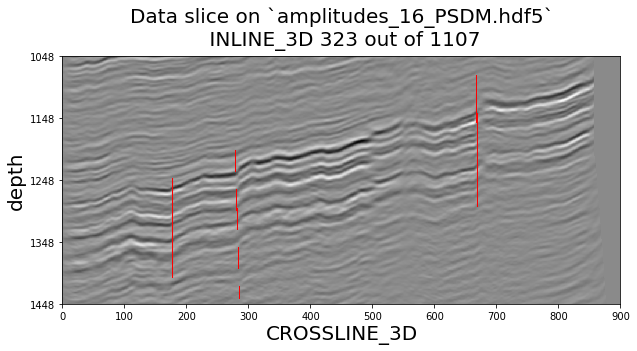

In [10]:
for i in range(len(dataset)):
    bounds = min([fault.points[:, 2].min() for fault in dataset.labels[i]]), max([fault.points[:, 2].max() for fault in dataset.labels[i]])
    points = np.random.choice(len(dataset.labels[i]), 3, replace=True)
    for p in points:
        dataset.show_slide(dataset.labels[i][p].points[0, 0], idx=i,
                           figsize=(10,10), zoom_slice = (slice(None, None), slice(*bounds)))

In [11]:
datasets = [list(itertools.combinations(datasets, i+1)) for i in range(2)]
datasets = sum(datasets, [])
datasets = [KV(item, '_'.join([os.path.splitext(os.path.basename(name))[0][11:] for name in item])) for item in datasets]
datasets

[KV(01_ETP: ('/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.hdf5',)),
 KV(16_PSDM: ('/data/seismic_data/seismic_interpretation/CUBE_16_PSDM/amplitudes_16_PSDM.hdf5',)),
 KV(01_ETP_16_PSDM: ('/data/seismic_data/seismic_interpretation/CUBE_01_ETP/amplitudes_01_ETP.hdf5', '/data/seismic_data/seismic_interpretation/CUBE_16_PSDM/amplitudes_16_PSDM.hdf5'))]

In [12]:
# option = [KV([i], os.path.basename(i)[11:-5]) for i in datasets]
# option = [KV(datasets[:-1], 'all-1')]
# option += [KV(datasets, 'all')]
# # option += [KV(datasets[:1]+datasets[2:], 'not_psdm')]

In [13]:
# import glob
# import tqdm
# for name in tqdm.tqdm_notebook(glob.glob('/data/seismic_data/seismic_interpretation/*/INPUTS/FAULTS/NPY/*')):
#     arr = np.load(name, allow_pickle=True)
#     np.save(name, arr, allow_pickle=False)

In [14]:
# option

Finally, define domain of parameters: paths to cubes and crop_shapes.

In [15]:
op1 = Option('paths', datasets) 
op2 = Option('crop', [(1, 128, 256), (1, 256, 256)]) 
op3 = Option('loss', [
    KV(Dice(), 'dice'),
    KV(Tversky(), 'tversky'),
#     KV(SSLoss(r=0.1), 'ss_0.1'),
#     KV(SSLoss(r=0.5), 'ss_0.5'),
#     KV(SSLoss(r=1), 'ss_1'),
#     KV(BCE(pos_weight=1), 'bce_1'),
#     KV(BCE(pos_weight=0.5), 'bce_0.5'),
#     KV(BCE(pos_weight=10), 'bce_10'),
])
domain = op2 * op3 * op1

Describe experiment plan as a research-pipeline. We well use 8 availiable gpus to train models in parallel to increase the speed several times.

In [16]:
! rm -r research_metrics

research = (Research()
    .init_domain(domain)
    .add_callable(create_dataset, pipeline=RP('train'), config=RC(), execute='#0')
    .add_pipeline(train_pipeline, name='train', variables='loss_history')
    .add_callable(dump_model, pipeline=RP('train'), path=REP(), iteration=RI(), execute='last', logging=True)
    .add_callable(compute_metrics, pipeline=RP('train'), config=RC(),
                  test_cube='/data/seismic_data/seismic_interpretation/CUBE_22_VALYNTOY/amplitudes_22_VALYNTOY.hdf5',
                  path=REP(), execute='last', returns='semblance', logging=True)
)

research.run(name='research_metrics', workers=6,
             devices=[0, 1, 2, 3, 4, 5])

Research research_metrics is starting...


Plot loss functions of all models.

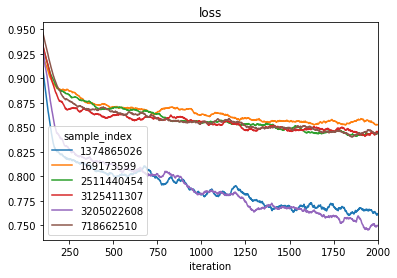

In [17]:
results = research.load_results().df
results = results[results.loss == 'dice']
(results
 .pivot(index='iteration', columns='sample_index', values='loss_history')
 .rolling(100).mean()
 .plot(xlim=(100, 2000), legend=True, title='loss')
)

In [18]:
results.sample_index.unique()

array(['3125411307', '169173599', '718662510', '1374865026', '2511440454',
       '3205022608'], dtype=object)

In [19]:
results[results.sample_index == '3107640017']

,name,loss_history,semblance,iteration,sample_index,crop,loss,paths,repetition,update


In [23]:
df = research.load_results(names='compute_metrics').df

In [25]:
df.sort_values('semblance')

,name,loss_history,semblance,iteration,sample_index,crop,loss,paths,repetition,update
3,compute_metrics,NaN,0.530104,2000,1051777978,"(1, 128, 256)",tversky,16_PSDM,0,0
11,compute_metrics,NaN,0.531053,2000,3205022608,"(1, 256, 256)",dice,16_PSDM,0,0
6,compute_metrics,NaN,0.546499,2000,1172614826,"(1, 256, 256)",tversky,01_ETP_16_PSDM,0,0
5,compute_metrics,NaN,0.547383,2000,3492943089,"(1, 256, 256)",tversky,16_PSDM,0,0
9,compute_metrics,NaN,0.548428,2000,1374865026,"(1, 128, 256)",dice,16_PSDM,0,0
2,compute_metrics,NaN,0.554812,2000,169173599,"(1, 128, 256)",dice,01_ETP,0,0
10,compute_metrics,NaN,0.574864,2000,2511440454,"(1, 256, 256)",dice,01_ETP,0,0
7,compute_metrics,NaN,0.578317,2000,77364812,"(1, 128, 256)",tversky,01_ETP_16_PSDM,0,0
8,compute_metrics,NaN,0.582794,2000,718662510,"(1, 256, 256)",dice,01_ETP_16_PSDM,0,0
0,compute_metrics,NaN,0.589588,2000,1408278127,"(1, 256, 256)",tversky,01_ETP,0,0


In [22]:
sample_index = results.groupby('sample_index').apply(lambda x: x.iloc[-1]['loss_history']).idxmin()
results[results.sample_index == sample_index]

,name,loss_history,semblance,iteration,sample_index,crop,loss,paths,repetition,update
